# 7. Gyakorlat: Felügyelet nélküli tanulás
Főkomponenselemzés, K-közép klaszterezés

In [14]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from fcmeans import FCM
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import FixedFormatter
from sklearn.metrics import silhouette_samples

from seaborn import scatterplot as scatter
from sklearn.metrics import silhouette_score
from pandas.plotting import register_matplotlib_converters

sns.set()
register_matplotlib_converters()

## Adatok beolvasása

    vszam - hányszor vettek adott termékből
    bevetel - összesen mennyi bevételt hozott a termék
    haszonkulcs - hány százalék haszon van a terméken
    vnap - hány napja vásárolták utóljára a terméket

In [2]:
termek_tulajdonsag = pd.read_csv('termek_tulajdonsag.csv', header=0, sep=',')

df_termek = termek_tulajdonsag.set_index('z_soid')

df_termek.loc[df_termek['haszonkulcs']>200, 'haszonkulcs'] = 200

df_termek.head()

,vszam,bevetel,haszonkulcs,vnap
z_soid,,,,
1,28,3348739.0,11.565714,1199
2,1,110228.0,10.110000,1884
3,49,695098.0,8.902449,7
4,37,665054.0,7.545676,0
5,1,101496.0,8.500000,940


## Előkészítés: soroljuk be az árakat 0...3 kategórákba

In [3]:
arak = pd.DataFrame(df_termek['bevetel'] / df_termek['vszam'], columns=['ar']).round()

def choose_boost(n):
    if(n<29990):
        return 0
    elif(n>=29990 and n<51077):
        return 1
    elif(n>=51077 and n<83330):
        return 2
    else:
        return 3
        
arak['cat'] = [choose_boost(n) for n in arak['ar']]

#df_termek = pd.concat([df_termek, arak['ar']], axis=1)

scaled_termek = preprocessing.scale(df_termek)

## Fuzzy C-means klaszterezés
> A fuzzy C-means (FCM) algoritmus egy klaszterezési módszer, ami hasonló a hagyományos k-means algoritmushoz, de néhány kulcsfontosságú különbséggel rendelkezik. A fuzzy C-means a "fuzzy" logikát alkalmazza a klaszterezés során, lehetővé téve, hogy egy adatpont egyszerre több klaszterhez is tartozhasson, bizonyos fokig.

In [4]:
fcm = FCM(n_clusters=5, random_state=42, max_iter=1000)
fcm.fit(scaled_termek)

fcm_centers = fcm.centers
u = pd.DataFrame(fcm.u)
fcm_labels  = fcm.u.argmax(axis=1)

y_pred_fuzzy = fcm.predict(scaled_termek)

print("FCM predikciók")
print(fcm.u[:10])
print()
print("Becsült értékek")
for i in range(10):
    print(y_pred_fuzzy[i])

FCM predikciók
[[0.27398655 0.21140929 0.17271004 0.14576226 0.19613185]
 [0.03422782 0.66323583 0.08094441 0.07910314 0.1424888 ]
 [0.19725173 0.09581848 0.31169219 0.19822879 0.19700881]
 [0.10681802 0.07863771 0.41121251 0.20134899 0.20198277]
 [0.01505852 0.42223098 0.1017332  0.0833877  0.3775896 ]
 [0.0028701  0.95173365 0.01037813 0.01021022 0.02480791]
 [0.00649478 0.01372316 0.85120762 0.05750838 0.07106607]
 [0.01187177 0.09230923 0.17736188 0.09618599 0.62227113]
 [0.06567206 0.06558803 0.47289927 0.20112838 0.19471226]
 [0.00773646 0.01485085 0.82832675 0.07727192 0.07181401]]

Becsült értékek
0
1
2
2
1
1
2
4
2
2


# Optimális klaszterszám megtalálása
## Könyök módszer

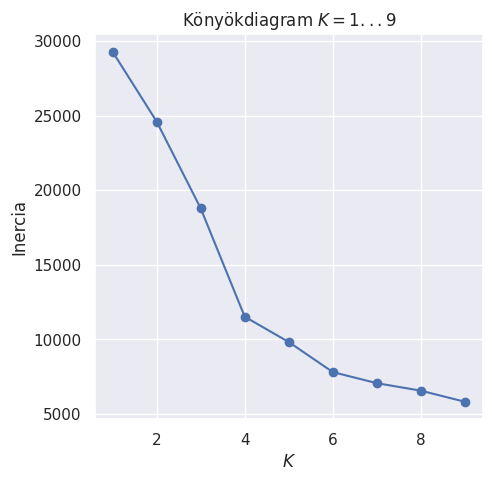

In [5]:
kmeans_per_k = [KMeans(
    n_clusters = k, 
    init = 'k-means++', 
    n_init = 1, 
    random_state = 42
    ).fit(scaled_termek) for k in range(1,10)]

inertia = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(5, 5))
plt.title("Könyökdiagram $K=1...9$")
plt.plot(range(1, len(inertia) + 1), inertia, 'bo-')
plt.xlabel('$K$')
plt.ylabel('Inercia')
plt.show()

## Sziluett módszer

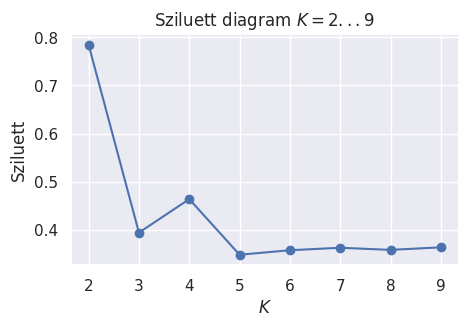

In [6]:
silhouettes = [silhouette_score(scaled_termek, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(5, 3))
plt.title("Sziluett diagram $K=2...9$")
plt.plot(range(2,10), silhouettes, 'bo-')
plt.xlabel('$K$')
plt.ylabel('Sziluett')
plt.show()

## K-Means 5 klaszterrel

In [8]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=100, max_iter=1000, random_state=42)
kmeans.fit(scaled_termek)

print('Inercia:', kmeans.inertia_)

y_pred = kmeans.predict(scaled_termek)

y_pred[:10]

Inercia: 9239.366415719958


array([2, 0, 2, 2, 0, 0, 1, 1, 1, 1], dtype=int32)

## Főkomponenselemzés

In [10]:
var_ratio = 2
pca = PCA(n_components=var_ratio)
pca.fit(scaled_termek)
pca_data = pca.transform(scaled_termek)

print('Főkomponensek száma: ', pca.n_components_)
print('Megőrzött varianciahányad: ', np.sum(pca.explained_variance_ratio_))

Főkomponensek száma:  2
Megőrzött varianciahányad:  0.7075336950581793


### PCA vizualizálása

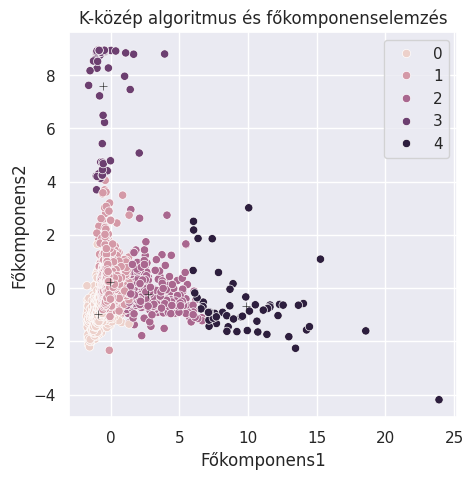

In [13]:
fs=20 # betűméret

create_pca_frame = lambda pcd: pd.DataFrame(pcd, columns = [str(x) for x in range(pcd.shape[1])])

pca_frame = create_pca_frame(pca_data)

pca_frame['pred'] = pd.Series(y_pred) #Klaszterek 

# pca_frame['pred'] = pd.Series(y_pred_fuzzy) #Fuzzy C-means klaszterek

#cluster center
centers = kmeans.cluster_centers_
pca_centers = pd.DataFrame(pca.transform(centers), columns=['0','1'])

plt.figure(figsize=(5,5))
plt.title('K-közép algoritmus és főkomponenselemzés')
ax = scatter(x='0', y='1', hue='pred', data=pca_frame)
ax = scatter(x='0', y='1', color=".2", marker="+", data=pca_centers)
ax.tick_params()
ax.legend(loc='upper right')
ax.set_xlabel('Főkomponens1')
ax.set_ylabel('Főkomponens2')
plt.show()

## Sziluett módszer a teljes konfigurációs térre

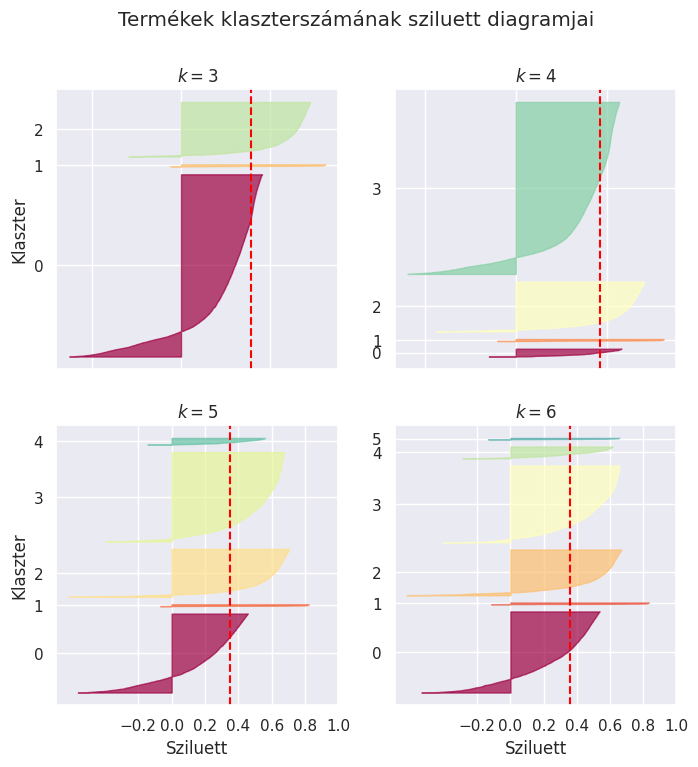

In [19]:
plt.figure(figsize=(8, 8))

for k in (3,4,5,6):
    plt.subplot(2, 2, k-2)
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coeffs = silhouette_samples(pca_data, y_pred)
    
    padding = len(pca_data) // 30
    
    pos = padding
    ticks = []

    for i in range(k):
        coeffs = silhouette_coeffs[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(
            y = np.arange(pos, pos+len(coeffs)), 
            x1 = 0, 
            x2 = coeffs, 
            facecolor=color, 
            edgecolor=color, 
            alpha=0.7
        )
        ticks.append(pos + len(coeffs) // 2)
        pos+=len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    if k in (3,5):
        plt.ylabel('Klaszter')
    
    if k in (5,6):
        plt.gca().set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Sziluett')
    else:
        plt.tick_params(labelbottom=False)
        
    plt.axvline(x=silhouettes[k-2], color="red", linestyle='--')
    plt.title('$k={}$'.format(k))

plt.suptitle('Termékek klaszterszámának sziluett diagramjai')
plt.show()

## Loading Score
> A loading score megadja, mennyiben felel a varianciáért adott változó

In [20]:
loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

loadings = pd.Series(loading_scores)
factors = pd.Series(df_termek.columns)
print(pd.concat([loadings, factors], axis=1))

          0            1
0  0.666689        vszam
1  0.662194      bevetel
2 -0.072784  haszonkulcs
3 -0.334256         vnap


## Scree Plot
> A scree plot a főkomponensek sorrendben történő megjelenítése, ahol az egyes komponensekhez tartozó variancia százalékát ábrázolja a tengelyeken.

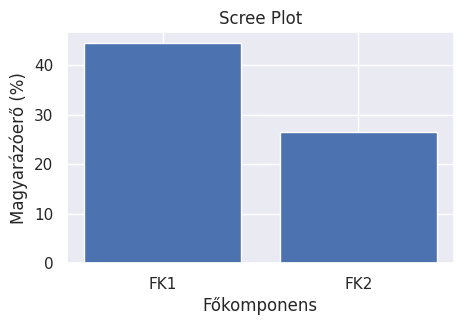

In [22]:
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['FK' + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(5, 3))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Magyarázóerő (%)')
plt.xlabel('Főkomponens')
plt.title('Scree Plot')
plt.show()

## Klaszterek statisztikai leírása

In [23]:
df_cluster = df_termek.copy().reset_index()

df_cluster['pred'] = pd.Series(y_pred)
df_cluster['cat'] = pd.Series(arak.reset_index()['cat'])

n = kmeans.n_clusters

df_stat = pd.DataFrame()
for i in range(n):
    stat = df_cluster[df_cluster['pred']==i][['vszam','bevetel','haszonkulcs','vnap']].describe()    
    df_stat = pd.concat([df_stat, stat], axis=0)

df_stat.index = [str(y)+'_'+str(int(x/8)) for x,y in zip(range(len(df_stat)), df_stat.index)]
df_stat = df_stat.sort_index(axis=0)

dict_stat = {j:df_stat.iloc[i:i+n,:] for i,j in zip(range(0, n*8, n), ['25','50','75','count','max','mean','min','std'])}

dict_stat

{'25':        vszam     bevetel  haszonkulcs    vnap
 25%_0    2.0    99407.50     6.473286   24.00
 25%_1    2.0     6447.75   195.886250   11.00
 25%_2    1.0    27818.75    11.419250  861.75
 25%_3    1.0     3489.00    22.808750   35.75
 25%_4   28.5  1528364.50     8.713546    5.00,
 '50':        vszam    bevetel  haszonkulcs    vnap
 50%_0    5.0   232658.0    10.052237   105.0
 50%_1    5.0    22890.5   200.000000    60.5
 50%_2    1.0    65366.0    15.305000  1085.5
 50%_3    2.0    12124.0    30.100000   135.5
 50%_4   47.0  2168195.0    11.749268    15.0,
 '75':        vszam     bevetel  haszonkulcs     vnap
 75%_0   11.0   522384.75    15.038750   308.00
 75%_1   10.0    87614.50   200.000000   323.00
 75%_2    3.0   155098.00    20.633333  1348.25
 75%_3    4.0    52777.50    30.980000   315.25
 75%_4   65.0  3062507.00    17.118671    50.00,
 'count':           vszam  bevetel  haszonkulcs    vnap
 count_0  2718.0   2718.0       2718.0  2718.0
 count_1    58.0     58.0     

## Klaszterek leíró statisztikáinak vizualizálása

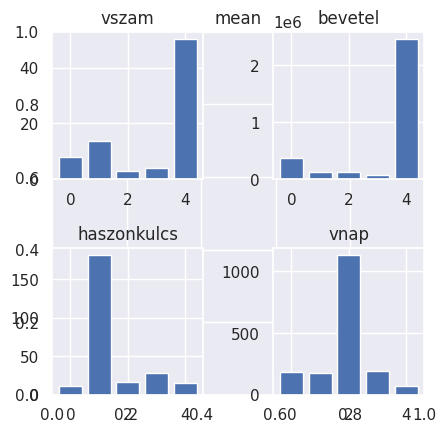

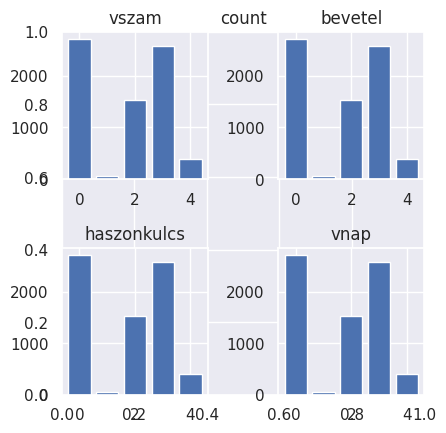

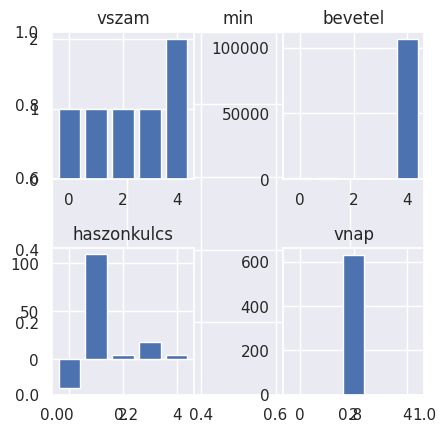

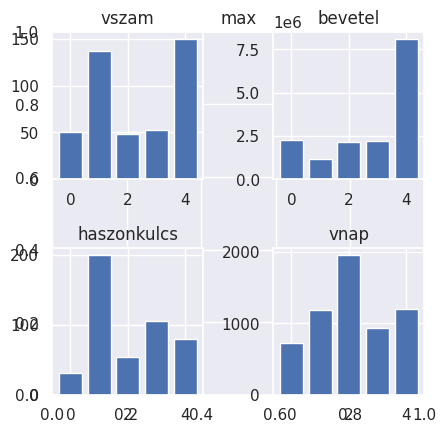

In [26]:
def print_stat(prop, j):
    fig = plt.figure(figsize=(5, 5))
    plt.title(prop)
    ax0 = fig.add_subplot(j,2,1)
    ax1 = fig.add_subplot(j,2,2)
    ax2 = fig.add_subplot(j,2,3)
    ax3 = fig.add_subplot(j,2,4)
    #ax4 = fig.add_subplot(j,2,5)
    ax0.bar(range(5),dict_stat[prop]['vszam'])
    ax0.set_title('vszam')
    ax1.bar(range(5),dict_stat[prop]['bevetel'])
    ax1.set_title('bevetel')
    ax2.bar(range(5),dict_stat[prop]['haszonkulcs'])
    ax2.set_title('haszonkulcs')
    ax3.bar(range(5),dict_stat[prop]['vnap'])
    ax3.set_title('vnap')
    #ax4.bar(range(5),dict_stat[prop]['ar'])
    #ax4.set_title('ar')
    plt.tight_layout()
    plt.show()


print_stat('mean', 2)
print_stat('count', 2)
print_stat('min', 2)
print_stat('max', 2)

## Különböző változók megoszlása a főkomponens diagramon
Figyeljük meg, hogy a négy vizsgált változó hogyan oszlik el a főkomponens diagramon!

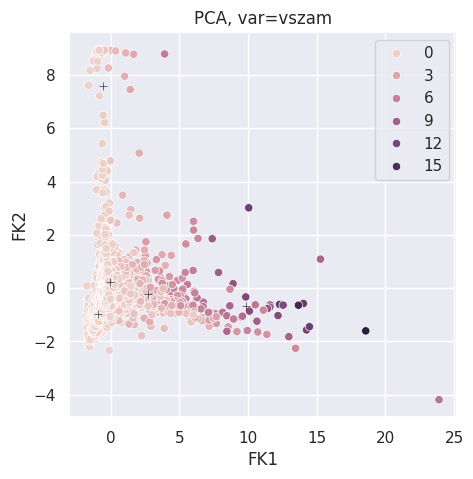

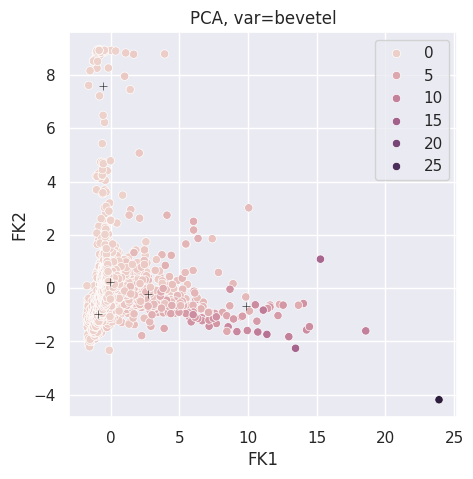

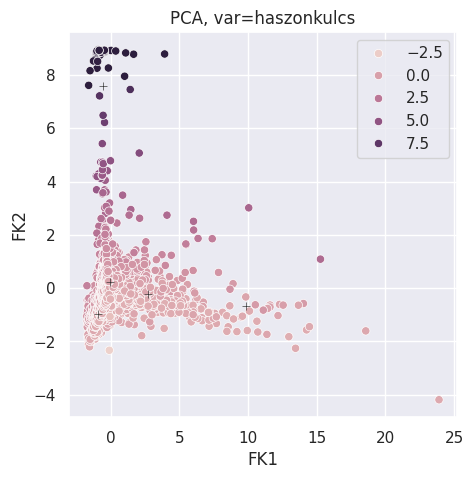

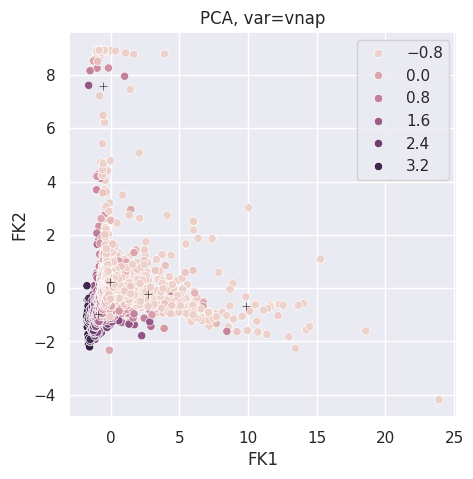

In [28]:
fs=20

create_pca_frame = lambda pcd: pd.DataFrame(pcd, columns = [str(x) for x in range(pcd.shape[1])])

pca_frame = create_pca_frame(pca_data)

pca_frame['pred'] = pd.Series(y_pred) #Klaszterek 

# pca_frame['pred'] = pd.Series(y_pred_fuzzy) #Fuzzy C-means klaszterek

# pca_frame['pred'] = arak.reset_index()['cat'] #Árkategóriák

scaled_frame = create_pca_frame(scaled_termek)
for x,y in zip(range(4), ['vszam','bevetel','haszonkulcs','vnap']):    
    pca_frame['pred'] = scaled_frame[str(x)]

    #cluster center
    centers = kmeans.cluster_centers_
    pca_centers = pd.DataFrame(pca.transform(centers), columns=['0','1'])

    plt.figure(figsize=(5, 5))
    plt.title('PCA, var='+y)
    ax = scatter(x='0', y='1', hue='pred', data=pca_frame)
    ax = scatter(x='0', y='1', color=".2", marker="+", data=pca_centers)
    ax.legend(loc='upper right')
    ax.tick_params()
    ax.set_xlabel('FK1')
    ax.set_ylabel('FK2')
    plt.show()